In [1]:
pip install rasterio pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopandas contextily

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas rasterio shapely geopy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.decomposition import PCA
from ipywidgets import interact
import numpy as np
import rasterio
import pandas as pd
import os
from sklearn.cluster import KMeans
import contextily as ctx
import pandas as pd
import geopandas as gpd
from rasterio.transform import from_origin
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape, LineString, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Import TIF files

In [6]:
# List of your TIFF files
tif_files = [
    './Datasets/Seismic/vsh_at_150km_original.tif',
    './Datasets/Seismic/vsh_at_160km_original.tif',
    './Datasets/Seismic/vsh_at_170km_original.tif',
    './Datasets/Seismic/vsh_at_180km_original.tif',
    './Datasets/Seismic/vsh_at_190km_original.tif',
    './Datasets/Seismic/vsh_at_200km_original.tif',  
    ]

data_frames = []

for tif in tif_files:
    with rasterio.open(tif) as src:
        data = src.read(1)  # Read the first band
        rows, cols = data.shape
        coords = [(src.xy(row, col)) for row in range(rows) for col in range(cols)]
        values = data.flatten()
        
        df = pd.DataFrame(coords, columns=["x", "y"])
        df[tif] = values
        
        data_frames.append(df)

# Merge all data frames on the coordinates
merged_df = data_frames[0]

for df in data_frames[1:]:
    merged_df = pd.merge(merged_df, df, on=["x", "y"], how="outer")

# Save to CSV
merged_df.to_csv("./Datasets/Seismic/VSH.csv", index=False)

print("CSV file created successfully.")


CSV file created successfully.


In [7]:
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point

# # Load the CSV file
# csv_file = "./Datasets/Seismic/VSH_Continental.csv"
# df = pd.read_csv(csv_file)

# # Convert the DataFrame to a GeoDataFrame
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326")

# # Load the shapefile
# shapefile = gpd.read_file("./Datasets/Frames/ContinentalPolygons.shp")

# # Clip the GeoDataFrame with the polygon shapefile
# clipped_gdf = gpd.clip(gdf, shapefile)

# # Save the clipped GeoDataFrame to a new CSV file
# output_csv = "./Datasets/Seismic/VSH_Continental_Clipped.csv"
# clipped_gdf.drop(columns="geometry").to_csv(output_csv, index=False)

# print("Clipped CSV file created successfully.")


# PCA

In [8]:
# you can change merged_df to clipped_gdf

In [9]:
# Extracting the values for PCA
value_columns = [tif for tif in tif_files]
values = merged_df[value_columns]

# Apply PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(values)

# Create a DataFrame with the principal components
pca_columns = [f"PC{i+1}" for i in range(6)]
pca_df = pd.DataFrame(data=principal_components, columns=pca_columns)

# Add coordinates to the PCA DataFrame
pca_df["x"] = merged_df["x"]
pca_df["y"] = merged_df["y"]

# Save PCA result to CSV
pca_df.to_csv(".\Datasets\Seismic\pca_VSH.csv", index=False)

print("PCA and CSV file created successfully.")


PCA and CSV file created successfully.


# Elbow

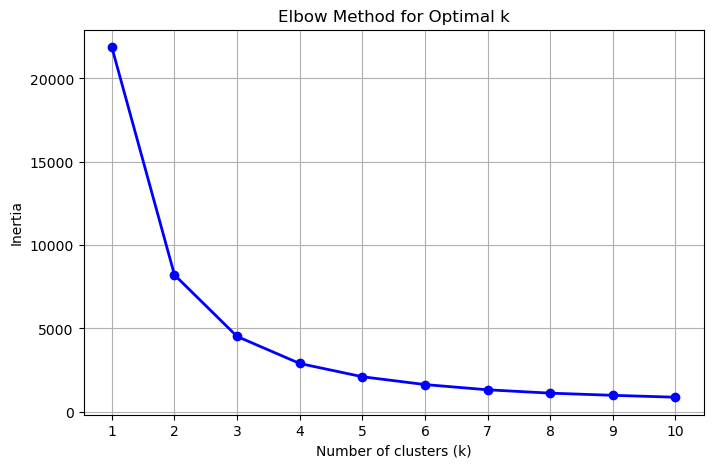

In [10]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method for KMeans
inertia = []
K = range(1, 11)  # You can adjust the range based on your dataset

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()


# EigenValues

In [11]:
import pandas as pd
from sklearn.decomposition import PCA

# Get eigenvalues and explained variance
eigenvalues = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_ * 100
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Create DataFrame for eigenvalues, percentage, and cumulative variance
pca_summary_df = pd.DataFrame({
    'PC Layer': [f"PC{i+1}" for i in range(len(eigenvalues))],
    'EigenValue': eigenvalues,
    'Percent of EigenValues': explained_variance_ratio,
    'Accumulative of EigenValues': cumulative_variance_ratio
})

# Display the DataFrame
print("PERCENT AND ACCUMULATIVE EIGENVALUES")
print(pca_summary_df)


PERCENT AND ACCUMULATIVE EIGENVALUES
  PC Layer    EigenValue  Percent of EigenValues  Accumulative of EigenValues
0      PC1  8.254062e-02            9.820238e+01                    98.202384
1      PC2  1.484506e-03            1.766186e+00                    99.968569
2      PC3  2.641810e-05            3.143084e-02                   100.000000
3      PC4  1.926847e-14            2.292459e-11                   100.000000
4      PC5  1.892628e-14            2.251747e-11                   100.000000
5      PC6  1.884488e-14            2.242062e-11                   100.000000


In [21]:
# Apply KMeans clustering on the first two principal components
kmeans = KMeans(
    n_clusters=5,
    # init='k-means++',
    # n_init='auto',
    # max_iter=300,
    # tol=0.0001,
    # verbose=0,
    random_state=42,
    # copy_x=True,
    # algorithm='lloyd',
)  # You can change the number of clusters
kmeans.fit(pca_df[["PC1"]]) #(pca_df[["PC1", "PC2", "PC3"]])

# Add the cluster labels to the DataFrame
pca_df["Cluster"] = kmeans.labels_

# Save the PCA and clustering result to CSV
pca_df.to_csv(".\Datasets\Seismic\kmeans_VSH.csv", index=False)

print("PCA, KMeans clustering, and CSV file created successfully.")


PCA, KMeans clustering, and CSV file created successfully.


# PLOT

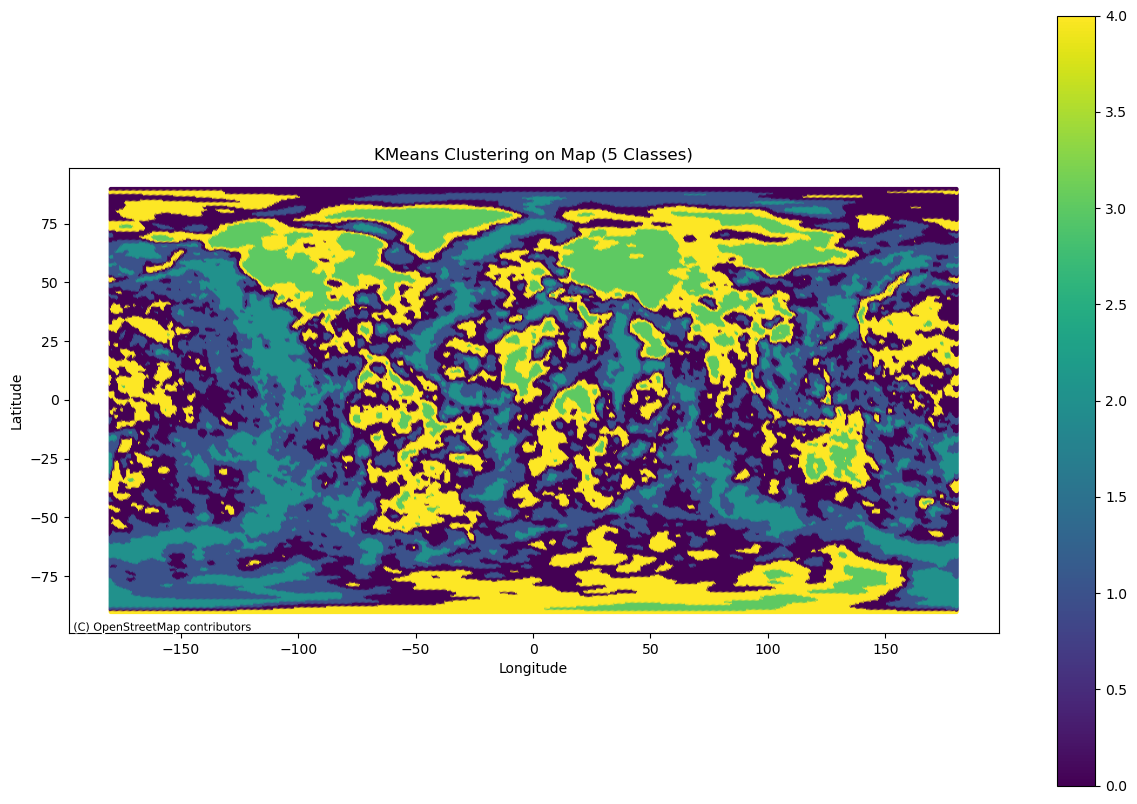

In [22]:
# Load the PCA and KMeans result CSV file
pca_kmeans_output_path = "./Datasets/Seismic/kmeans_VSH.csv"
pca_kmeans_df = pd.read_csv(pca_kmeans_output_path)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    pca_kmeans_df, 
    geometry=gpd.points_from_xy(pca_kmeans_df.x, pca_kmeans_df.y),
    crs="EPSG:4326"  # WGS 1984
)

# Plotting the clusters on the map based on x and y coordinates
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Scatter plot of the clusters on the map
gdf.plot(column='Cluster', ax=ax, legend=True, cmap='viridis', markersize=5)

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Adding labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clustering on Map (5 Classes)")

# Show plot
plt.show()


In [20]:
# Load the PCA and KMeans result CSV file
pca_kmeans_output_path = "./Datasets/Seismic/kmeans_VSH.csv"
pca_kmeans_df = pd.read_csv(pca_kmeans_output_path)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    pca_kmeans_df, 
    geometry=gpd.points_from_xy(pca_kmeans_df.x, pca_kmeans_df.y),
    crs="EPSG:4326"  # WGS 1984
)

# Define the raster resolution
pixel_size = 0.5  # Define the resolution in degrees
x_min, y_min, x_max, y_max = gdf.total_bounds

# Create grid
n_cols = int((x_max - x_min) / pixel_size) + 1
n_rows = int((y_max - y_min) / pixel_size) + 1

# Create an array to hold the raster values
raster = np.full((n_rows, n_cols), -1, dtype=np.int32)  # Initialize with -1 for no data

# Populate the raster array with cluster values
for idx, gdf_row in gdf.iterrows():
    col = int((gdf_row.geometry.x - x_min) / pixel_size)
    row_idx = n_rows - int((gdf_row.geometry.y - y_min) / pixel_size) - 1
    raster[row_idx, col] = int(gdf_row['Cluster'])

# Define the transform for the raster
transform = from_origin(x_min, y_max, pixel_size, pixel_size)

# Save the raster to a TIFF file
tiff_file_path = "./Datasets/Seismic/kmeans_clustering_VSH.tiff"
with rasterio.open(
    tiff_file_path,
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs='EPSG:4326',
    transform=transform,
) as dst:
    dst.write(raster, 1)

tiff_file_path


'./Datasets/Seismic/kmeans_clustering_VSH.tiff'

# Convert to Polyline--> 

In [15]:

# Step 1: Convert raster to polylines (boundaries)
# Path to your clustered raster file
raster_path = './Datasets/Seismic/kmeans_clustering_VSH.tiff'

# Read the raster file
with rasterio.open(raster_path) as src:
    image = src.read(1)  # Read the first band
    mask = image != src.nodata

    # Generate shapes (polygons) from the raster
    results = (
        {'properties': {'raster_val': v}, 'geometry': shape(s).exterior}
        for i, (s, v) in enumerate(
            shapes(image, mask=mask, transform=src.transform))
    )

# Convert shapes to GeoDataFrame
geoms = list(results)
polylines_gdf = gpd.GeoDataFrame.from_features(geoms)

# Convert LinearRing to LineString if necessary
polylines_gdf['geometry'] = polylines_gdf['geometry'].apply(
    lambda geom: LineString(geom) if geom.geom_type == 'LinearRing' else geom
)

# Ensure all geometries are valid
polylines_gdf = polylines_gdf[polylines_gdf.is_valid]

# Set the CRS for the polylines GeoDataFrame
polylines_gdf.set_crs(src.crs, inplace=True)

# Save the polylines to a shapefile (optional)
polyline_shapefile_path = './Datasets/Output/Kmeans_Line_VSH.shp'
polylines_gdf.to_file(polyline_shapefile_path, driver='ESRI Shapefile', schema={'geometry': 'LineString', 'properties': {'raster_val': 'int'}})


# Nearest distance--> and CDF

In [16]:
# import numpy as np
# import geopandas as gpd
# from scipy.spatial import cKDTree
# from shapely.geometry import MultiLineString, LineString

# EARTH_RADIUS = 6371.0  # Earth radius in kilometers

# def lonlat2xyz(lons, lats):
#     """Convert longitude and latitude to Cartesian coordinates."""
#     lons, lats = np.radians(lons), np.radians(lats)
#     x = EARTH_RADIUS * np.cos(lats) * np.cos(lons)
#     y = EARTH_RADIUS * np.cos(lats) * np.sin(lons)
#     z = EARTH_RADIUS * np.sin(lats)
#     return x, y, z

# def KD_dist(lons0, lats0, lons1, lats1, k=1):
#     """Function to efficiently query nearest-neighbour distances."""
#     x0, y0, z0 = lonlat2xyz(lons0, lats0)
#     x1, y1, z1 = lonlat2xyz(lons1, lats1)
    
#     tree = cKDTree(np.c_[x0, y0, z0])
#     d, idx = tree.query(np.c_[x1, y1, z1], k=k)
#     return d, idx

# def extract_coordinates(geometry):
#     """Extracts coordinates from a LineString or MultiLineString geometry."""
#     if isinstance(geometry, LineString):
#         return np.array(geometry.coords)
#     elif isinstance(geometry, MultiLineString):
#         coords = []
#         for line in geometry.geoms:
#             coords.extend(line.coords)
#         return np.array(coords)
#     else:
#         raise TypeError("Geometry must be a LineString or MultiLineString")

# # # Load GeoDataFrames (replace 'points_file' and 'polylines_file' with your file paths)
# # points_gdf = gpd.read_file('points_file.shp')
# # polylines_gdf = gpd.read_file('polylines_file.shp')

# # Ensure both GeoDataFrames are in the same coordinate system (WGS84 for geodesic calculations)
# points_gdf = points_gdf.to_crs("EPSG:4326")
# polylines_gdf = polylines_gdf.to_crs("EPSG:4326")

# # Merge all polylines into a single merged polyline
# merged_polyline = polylines_gdf.unary_union

# # Extract coordinates from points and merged polyline
# points_coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
# polylines_coords = extract_coordinates(merged_polyline)

# # Separate longitude and latitude for points and polylines
# lons0, lats0 = points_coords[:, 0], points_coords[:, 1]
# lons1, lats1 = polylines_coords[:, 0], polylines_coords[:, 1]

# # Calculate nearest distances using KD-tree
# distances, indices = KD_dist(lons1, lats1, lons0, lats0)

# # Add the distances to the points GeoDataFrame
# points_gdf['nearest_distance_km'] = distances

# # Save the updated points GeoDataFrame to a new file
# output_file = './Datasets/Output/points_with_distances.shp'
# points_gdf.to_file(output_file)

# print("Distance calculation completed and saved to", output_file)


In [17]:
# Step 2: Load Mineral_Occurrences points from a shapefile
points_path = './Datasets/Output/All_Deposits.shp'
points_gdf = gpd.read_file(points_path)

# Ensure all geometries are valid
points_gdf = points_gdf[points_gdf.is_valid]

# Ensure both GeoDataFrames have the same CRS
polylines_gdf = polylines_gdf.to_crs(points_gdf.crs)

In [ ]:
# Step 2: Load Mineral_Occurrences points from a shapefile
points_path = './Datasets/Output/All_Deposits.shp'
points_gdf = gpd.read_file(points_path)

# Ensure all geometries are valid
points_gdf = points_gdf[points_gdf.is_valid]

# Ensure both GeoDataFrames have the same CRS
polylines_gdf = polylines_gdf.to_crs(points_gdf.crs)

In [ ]:
# # Plot the points and polylines
# fig, ax = plt.subplots(figsize=(10, 10))
# polylines_gdf.plot(ax=ax, color='k')
# points_gdf.plot(ax=ax, color='red', markersize=5)
# plt.title('All Mineral Occurrences and Boundaries')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# # Step 4: Create a CDF plot of the nearest distances
# distances = (points_gdf['DIS2'].values)/1000
# distances.sort()

# cdf = np.arange(len(distances)) / float(len(distances))

# plt.figure(figsize=(10, 6))
# plt.plot(distances, cdf, marker='.', linestyle='none')
# plt.xlabel('Distance from Boundaries (km)')
# plt.ylabel('Cumulative frequency (%)')
# plt.title('CDF of Nearest Distances to Boundaries')
# plt.grid(True)
# plt.show()

# # Save the points with distances to a new file (optional)
# output_points_path = './Datasets/Output/All_Deposits.shp'
# points_gdf.to_file(output_points_path)

# print(f"Polylines saved to {polyline_shapefile_path}")
# print(f"Points with distances saved to {output_points_path}")

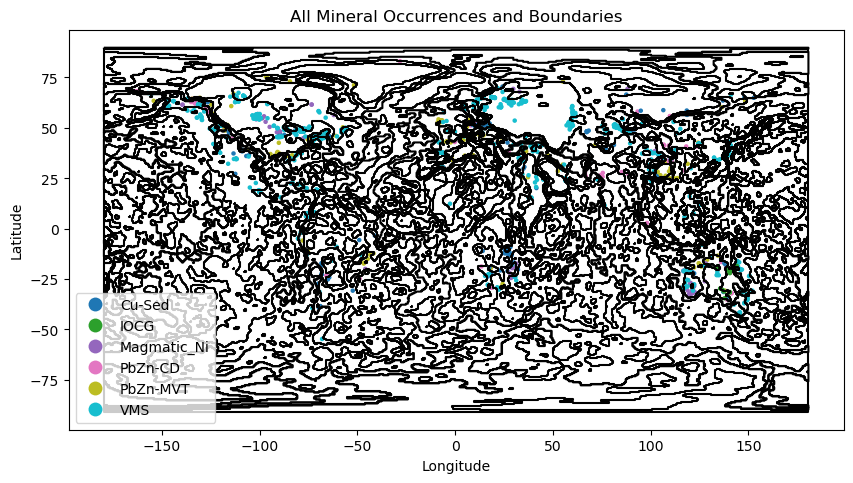

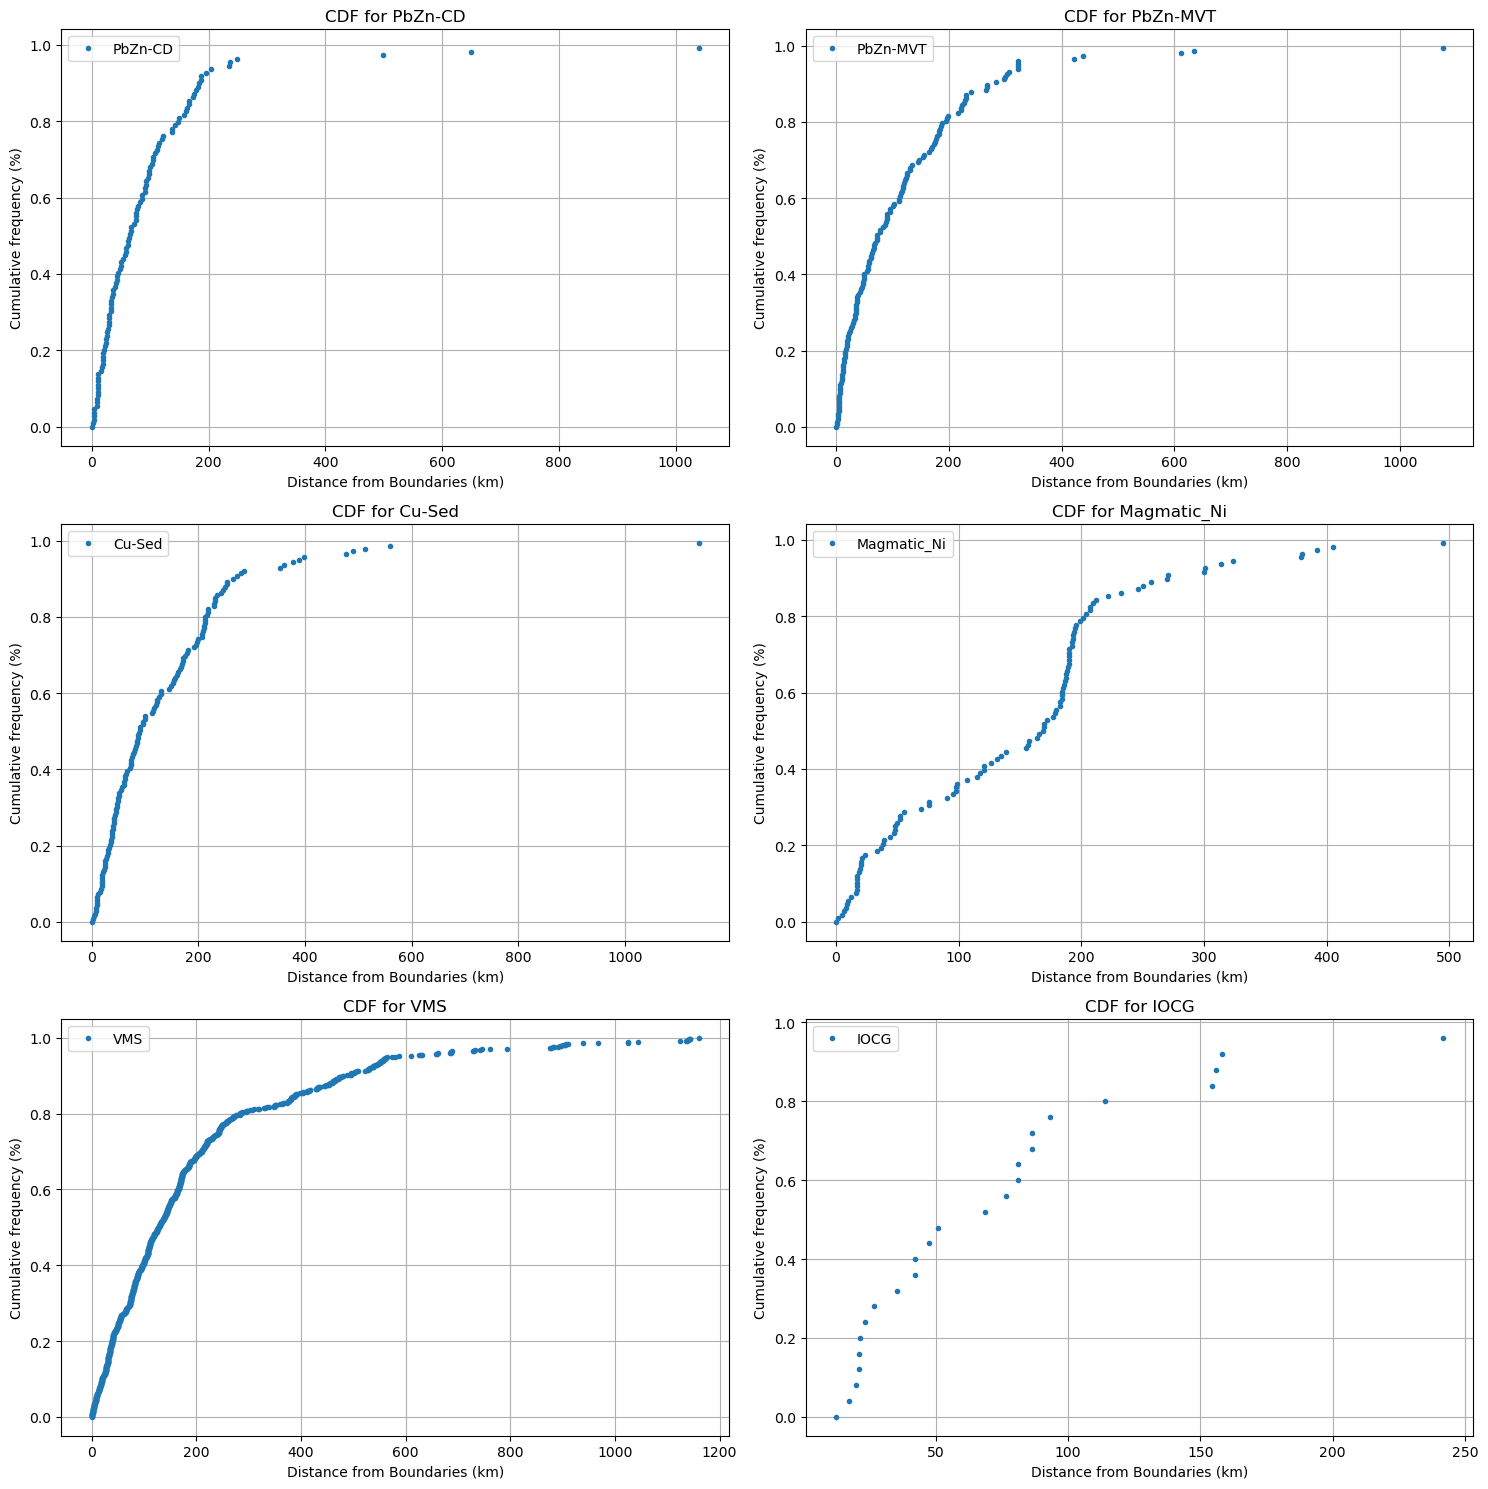

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Plot the points and polylines with points colored by the "Type" column
fig, ax = plt.subplots(figsize=(10, 10))
polylines_gdf.plot(ax=ax, color='k')
points_gdf.plot(ax=ax, column='Type', legend=True, markersize=5, cmap='tab10')
plt.title('All Mineral Occurrences and Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Step 4: Create separate CDF plots for each deposit type
types = points_gdf['Type'].unique()

# Create subplots with 2 columns and 3 rows
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate

for i, deposit_type in enumerate(types):
    if i >= len(axes):
        break  # If there are more types than subplots, stop plotting
    ax = axes[i]
    subset = points_gdf[points_gdf['Type'] == deposit_type]
    distances = (subset['DISTVSH2'].values) / 1000  # Convert distances to kilometers
    distances.sort()
    
    cdf = np.arange(len(distances)) / float(len(distances))
    
    ax.plot(distances, cdf, marker='.', linestyle='none', label=deposit_type)
    ax.set_xlabel('Distance from Boundaries (km)')
    ax.set_ylabel('Cumulative frequency (%)')
    ax.set_title(f'CDF for {deposit_type}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

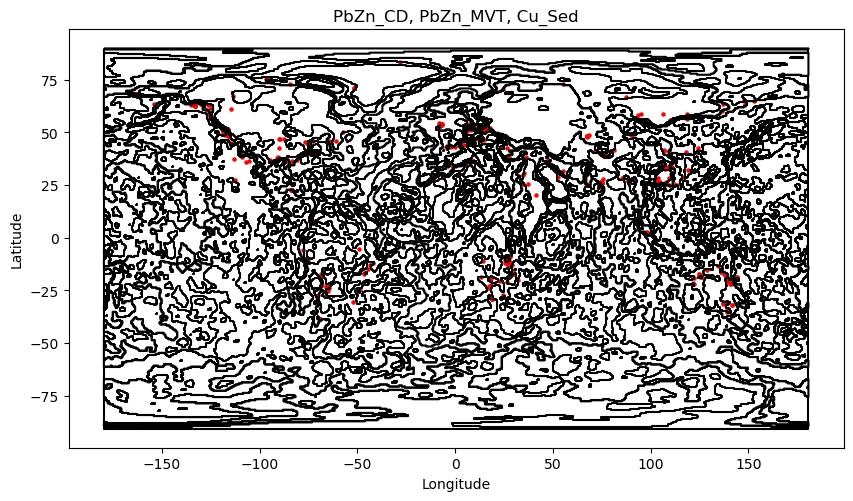

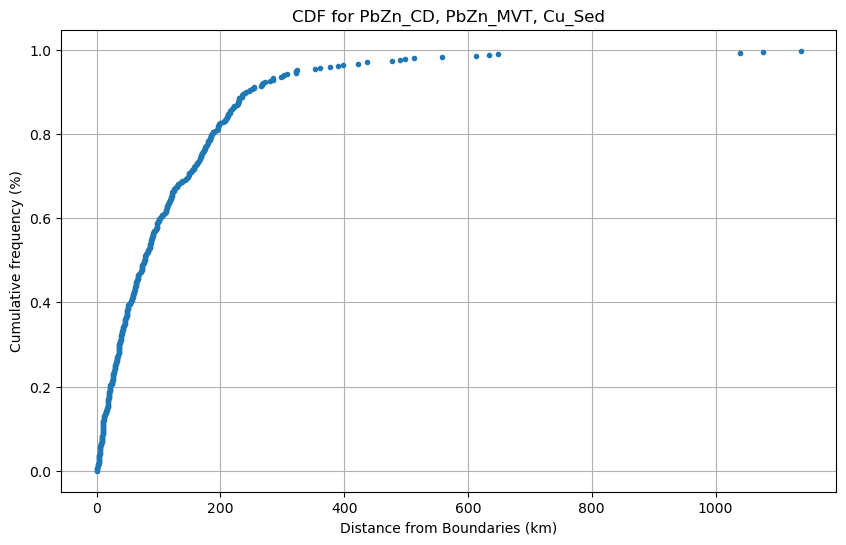

In [64]:
# Exclude "Magmatic_Ni" and "VMS" types
excluded_types = ["Magmatic_Ni", "VMS", "IOCG"]
points_gdf_e = points_gdf[~points_gdf['Type'].isin(excluded_types)]

# Plot the points and polylines
fig, ax = plt.subplots(figsize=(10, 10))
polylines_gdf.plot(ax=ax, color='k')
points_gdf_e.plot(ax=ax, color='red', markersize=5)
plt.title('PbZn_CD, PbZn_MVT, Cu_Sed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Step 4: Create a CDF plot of the nearest distances
distances = (points_gdf_e['DISTVSH2'].values)/1000
distances.sort()

cdf = np.arange(len(distances)) / float(len(distances))

plt.figure(figsize=(10, 6))
plt.plot(distances, cdf, marker='.', linestyle='none')
plt.xlabel('Distance from Boundaries (km)')
plt.ylabel('Cumulative frequency (%)')
plt.title('CDF for PbZn_CD, PbZn_MVT, Cu_Sed')
plt.grid(True)
plt.show()



In [12]:
# Weighted CDF

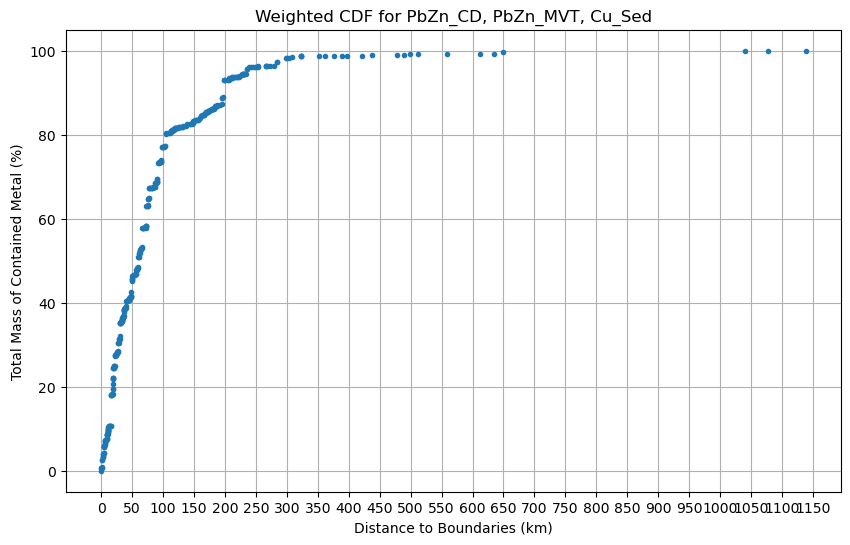

In [57]:

# # Load the polylines and points with distances
# polylines_gdf_path = './Datasets/Output/Kmeans_Line_VSV_VSH_VPV.shp'
# points_path = './Datasets/Output/PbZn_CD_VSV_VSH_VPV.shp'

# polylines_gdf = gpd.read_file(polylines_gdf_path)
# points_gdf = gpd.read_file(points_path)

# # Ensure all geometries are valid
# polylines_gdf = polylines_gdf[polylines_gdf.is_valid]
# points_gdf = points_gdf[points_gdf.is_valid]

# # Ensure both GeoDataFrames have the same CRS
# polylines_gdf = polylines_gdf.to_crs(points_gdf.crs)

# # Function to find the nearest distance from a point to a GeoDataFrame of polylines
# def nearest_distance_geodesic(point, polylines_gdf):
#     # Get the nearest polyline point to the given point
#     nearest_geom = nearest_points(point, polylines_gdf.unary_union)[1]
#     # Calculate the geodesic distance
#     point_coords = (point.y, point.x)
#     nearest_geom_coords = (nearest_geom.y, nearest_geom.x)
#     return geodesic(point_coords, nearest_geom_coords).kilometers

# # Calculate the nearest geodesic distance from each point to the polylines
# points_gdf['nearest_dis'] = points_gdf.geometry.apply(
#     lambda point: nearest_distance_geodesic(point, polylines_gdf)
# )

# Exclude "Magmatic_Ni" and "VMS" types
excluded_types = ["Magmatic_Ni", "VMS"]
points_gdf_e = points_gdf_e[~points_gdf_e['Type'].isin(excluded_types)]

# Extract relevant data
points_gdf_e = points_gdf_e.dropna(subset=['Ore__Mt_', 'DISTVSH2'])
ore_values = points_gdf_e['Ore__Mt_'].values
distances = (points_gdf_e['DISTVSH2'].values)/1000

# Sort by distances
sorted_indices = np.argsort(distances)
distances_sorted = distances[sorted_indices]
ore_values_sorted = ore_values[sorted_indices]

# Calculate the cumulative sum of ore values
cumulative_ore = np.cumsum(ore_values_sorted)

# Normalize to get the percentage
total_ore = cumulative_ore[-1]
cdf_percentage = (cumulative_ore / total_ore) * 100

# # Plot the CDF
# plt.figure(figsize=(10, 6))
# plt.plot(distances_sorted, cdf_percentage, marker='.', linestyle='none')
# plt.xlabel('Distance to Boundaries (km)')
# plt.ylabel('Total Mass of Contained Metal (%)')
# plt.title('Weighted CDF for PbZn_CD, PbZn_MVT, Cu_Sed')
# plt.grid(True)
# plt.show()

# Plot the CDF with x-axis intervals of 20 units
plt.figure(figsize=(10, 6))
plt.plot(distances_sorted, cdf_percentage, marker='.', linestyle='none')
plt.xticks(np.arange(0, max(distances_sorted) + 50, 50))
plt.xlabel('Distance to Boundaries (km)')
plt.ylabel('Total Mass of Contained Metal (%)')
plt.title('Weighted CDF for PbZn_CD, PbZn_MVT, Cu_Sed, IOCG')
plt.grid(True)
plt.show()

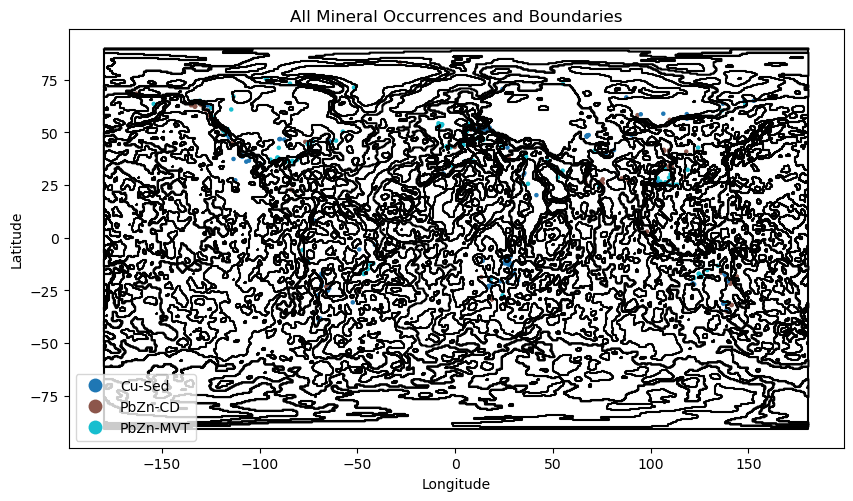

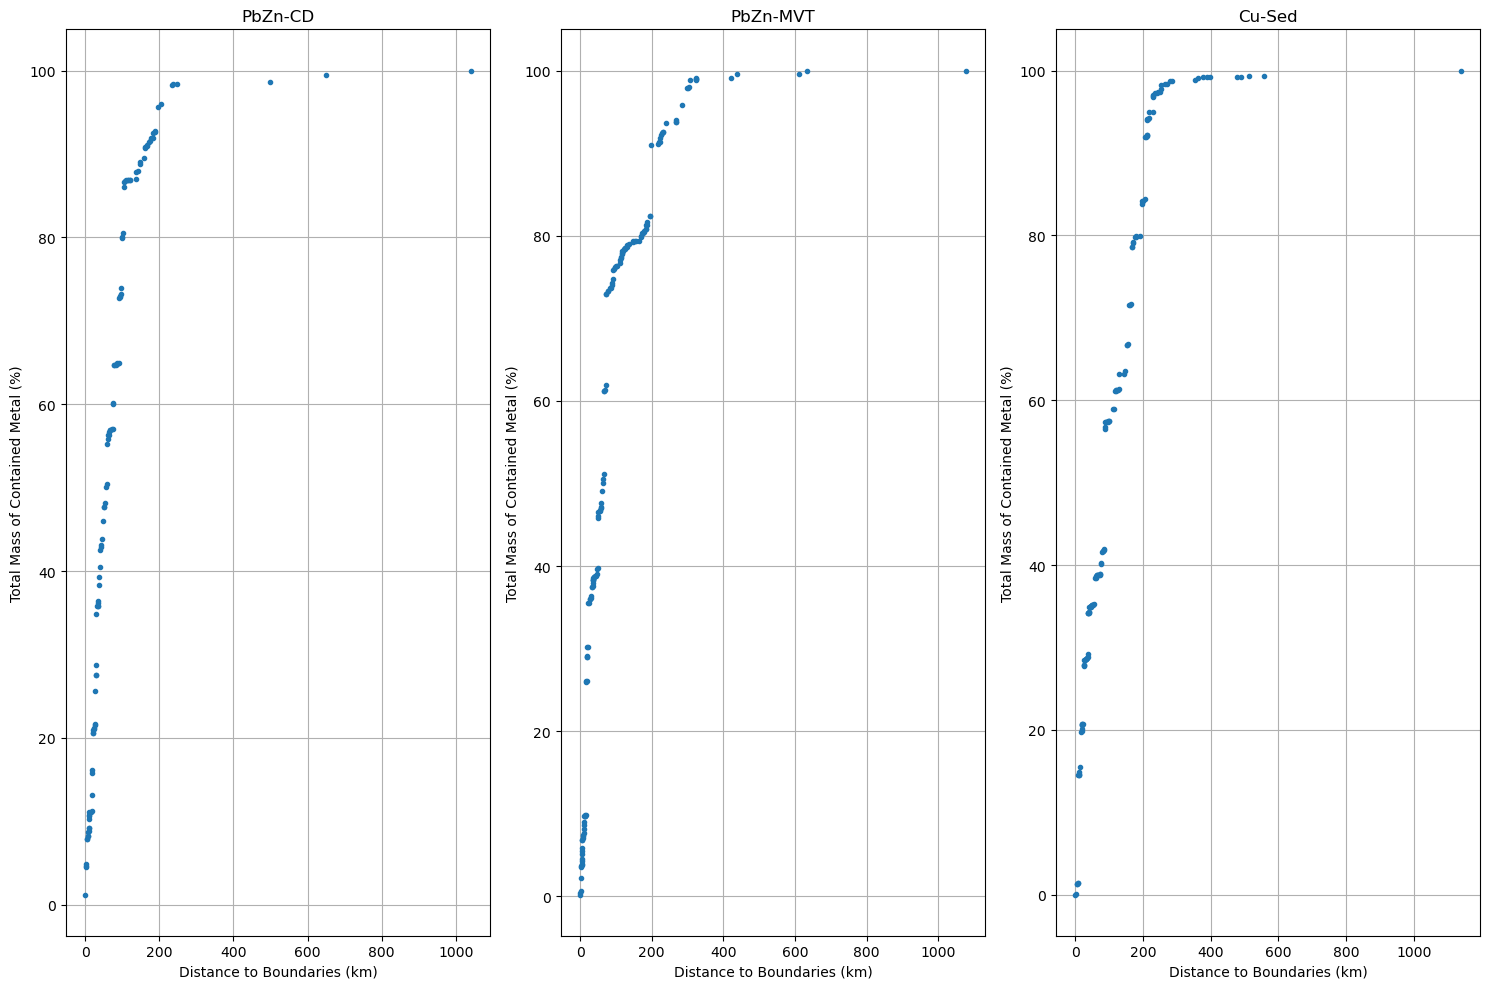

In [54]:
# Replace NaN and zero values in 'Ore__Mt_' with 0.1
points_gdf_e['Ore__Mt_'] = points_gdf_e['Ore__Mt_'].fillna(0.1)
points_gdf_e.loc[points_gdf_e['Ore__Mt_'] == 0, 'Ore__Mt_'] = 0.1

# Plot the points and polylines with points colored by the "Type" column
fig, ax = plt.subplots(figsize=(10, 10))
polylines_gdf.plot(ax=ax, color='k')
points_gdf_e.plot(ax=ax, column='Type', legend=True, markersize=5, cmap='tab10')
plt.title('All Mineral Occurrences and Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Prepare and plot CDF for each deposit type
types = points_gdf_e['Type'].unique()

# Create subplots with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate

for i, deposit_type in enumerate(types):
    if i >= len(axes):
        break  # If there are more types than subplots, stop plotting
    ax = axes[i]
    # Filter the data for the current deposit type
    subset = points_gdf_e[points_gdf_e['Type'] == deposit_type].dropna(subset=['DISTVSH2'])
    
    if subset.empty:
        continue  # Skip if there are no valid data points for the current deposit type

    ore_values = subset['Ore__Mt_'].values
    distances = subset['DISTVSH2'].values

    # Sort by distances
    sorted_indices = np.argsort(distances)
    distances_sorted = distances[sorted_indices] / 1000  # Convert distances to kilometers
    ore_values_sorted = ore_values[sorted_indices]

    # Calculate the cumulative sum of ore values
    cumulative_ore = np.cumsum(ore_values_sorted)

    # Normalize to get the percentage
    total_ore = cumulative_ore[-1]
    if total_ore == 0:
        continue  # Skip if the total ore is zero to avoid division by zero

    cdf_percentage = (cumulative_ore / total_ore) * 100

    
    # Plot the CDF for the current deposit type
    ax.plot(distances_sorted, cdf_percentage, marker='.', linestyle='none')
    ax.set_xlabel('Distance to Boundaries (km)')
    ax.set_ylabel('Total Mass of Contained Metal (%)')
    ax.set_title(f'{deposit_type}')
    ax.grid(True)


# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

In [65]:
# Replace NaN and zero values in 'Ore__Mt_' with 0.1
points_gdf_e2['Ore__Mt_'] = points_gdf_e2['Ore__Mt_'].fillna(0.1)
points_gdf_e2.loc[points_gdf_e2['Ore__Mt_'] == 0, 'Ore__Mt_'] = 0.1

# Plot the points and polylines with points colored by the "Type" column
fig, ax = plt.subplots(figsize=(10, 10))
polylines_gdf.plot(ax=ax, color='k')
points_gdf_e2.plot(ax=ax, column='Type', legend=True, markersize=5, cmap='tab10')
plt.title('All Mineral Occurrences and Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Prepare and plot CDF for each deposit type
types = points_gdf_e2['Type'].unique()

# Create subplots with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate

for i, deposit_type in enumerate(types):
    if i >= len(axes):
        break  # If there are more types than subplots, stop plotting
    ax = axes[i]
    # Filter the data for the current deposit type
    subset = points_gdf_e2[points_gdf_e2['Type'] == deposit_type].dropna(subset=['DISTVSH2'])
    
    if subset.empty:
        continue  # Skip if there are no valid data points for the current deposit type

    ore_values = subset['Ore__Mt_'].values
    distances = subset['DISTVSH2'].values

    # Sort by distances
    sorted_indices = np.argsort(distances)
    distances_sorted = distances[sorted_indices] / 1000  # Convert distances to kilometers
    ore_values_sorted = ore_values[sorted_indices]

    # Calculate the cumulative sum of ore values
    cumulative_ore = np.cumsum(ore_values_sorted)

    # Normalize to get the percentage
    total_ore = cumulative_ore[-1]
    if total_ore == 0:
        continue  # Skip if the total ore is zero to avoid division by zero

    cdf_percentage = (cumulative_ore / total_ore) * 100

    
    # Plot the CDF for the current deposit type
    ax.plot(distances_sorted, cdf_percentage, marker='.', linestyle='none')
    ax.set_xlabel('Distance to Boundaries (km)')
    ax.set_ylabel('Total Mass of Contained Metal (%)')
    ax.set_title(f'{deposit_type}')
    ax.grid(True)


# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

NameError: name 'points_gdf_e2' is not defined